In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
train_df = pd.read_excel("data/train.xlsx")
test1_df = pd.read_excel("data/testA.xlsx")
test2_df = pd.read_excel("data/testB.xlsx")

In [3]:
train_y = train_df[train_df.columns[-1]]
train_y.shape

(800,)

In [5]:
train_df = train_df[train_y>1.8]
train_y = train_y[train_y>1.8]
print(train_df.shape, train_y.shape)

(799, 5954) (799,)


In [6]:
new_column = test1_df.columns
train_df = train_df[new_column]
train_id = train_df['ID']
test1_id = test1_df['ID']
test2_id = test2_df['ID']
train_df.drop(['ID'], axis=1, inplace=True)
test1_df.drop(['ID'], axis=1, inplace=True)
test2_df.drop(['ID'], axis=1, inplace=True)

In [9]:
names = train_df.columns
dts = train_df.dtypes
drop_names = []
year = []
ints = []
objs = []
ratio = 0.1
for i in range(len(names)):
    n = names[i]
    tp = dts[i]
    trd = train_df[n]
    ted = test1_df[n]
    if 'object' == str(tp):
        objs.append(n)
    else:
        misstr = np.sum(trd.isnull())/500
        misste = np.sum(ted.isnull())/100
        if np.abs(misstr-misste) > ratio:
            drop_names.append(n)
        else:
            trrd = trd[trd.notnull()].values
            terd = ted[ted.notnull()].values
            if (str(trrd[0])[:4] == '2017' and str(trrd[700])[:4] == '2017') or (str(trrd[0])[:4] == '2016' and str(trrd[700])[:4] == '2016'):
                    year.append(n)
            elif 'int' in str(tp):
                ints.append(n)
            else:
                m1 = np.mean(trrd)
                s1 = np.std(trrd)
                m2 = np.mean(terd)
                s2 = np.std(terd)
                if np.abs(m1-m2)>ratio*np.abs(m1) and np.abs(s1-s2)>ratio*np.abs(s1):
                    drop_names.append(n)
print(len(drop_names),len(year), len(ints), len(objs))
print()

2328 40 541 11



In [10]:
train_df.drop(drop_names, axis=1, inplace=True)
test1_df.drop(drop_names, axis=1, inplace=True)
test2_df.drop(drop_names, axis=1, inplace=True)

In [11]:
df_X = pd.concat([train_df, test1_df, test2_df], axis=0)

In [12]:
np.sum(df_X[objs].isnull().values)

0

In [13]:
ints += objs
print(len(ints))

552


In [100]:
remains1 = []
remains2 = []
tobedrop = []

for n in ints:
    lu1 = len(train_df[n].unique())
    lu2 = len(df_X[n].unique())
    if lu1 < 15 and lu1 > 1:
        remains1.append(n)
    if lu2 < 15 and lu2 > 1:
        remains2.append(n)
    if lu1 != lu2:
        tobedrop.append(n)
    
print(len(remains1), len(remains2), len(tobedrop), len(year))

142 179 189 40


In [101]:
toberemain = list(set(remains1) & set(remains2) - set(tobedrop))
print(len(toberemain))

86


In [102]:
def dict2list(dic:dict):
    ''' 将字典转化为列表 '''
    keys = dic.keys()
    vals = dic.values()
    lst = [(key, val) for key, val in zip(keys, vals)]
    return lst

def LastRemainJudge(column):
    unique = set(column)
    uf = {}
    for u in unique:
        uf[u] = 0
    for c in column:
        uf[c] += 1
    sl = sorted(dict2list(uf), key = lambda x:x[1], reverse=True)
    x = sl[0][1]/len(column)
    sl = np.array(sl)
    if x < 0.8:
        #print(sl[:, 1]/len(column))
        return True
    else:
        return False

In [103]:
lm1 = []
lm2 = []
for n in toberemain:
    if LastRemainJudge(train_df[n]):
        lm1.append(n)
    if LastRemainJudge(df_X[n]):
        lm2.append(n)
print(len(lm1), len(lm2), len(set(lm1)&set(lm2)))

54 53 53


In [104]:
names = df_X.columns
dts = df_X.dtypes
dfx_float_n = []
dfx_onehot_n = list(set(lm1) & set(lm2))
print(len(dfx_onehot_n))
for i in range(len(names)):
    n = names[i]
    d = dts[i]
    if 'float' in str(d):
        dfx_float_n.append(n)
print(len(dfx_float_n))
dfx_float = df_X[dfx_float_n]
dfx_onehot = df_X[dfx_onehot_n]
print(dfx_float.shape, dfx_onehot.shape)

53
3095
(1511, 3095) (1511, 53)


In [21]:
floatyear = []
for n in dfx_float.columns:
    c = dfx_float[n]
    r = c[c.notnull()].astype(np.int64).values
    if (str(r[0])[:4] == '2017' and str(r[-1])[:4] == '2017') or (str(r[0])[:4] == '2016' and str(r[-1])[:4] == '2016'):
        floatyear.append(n)
print(floatyear)

['210X24', '210X205', '210X213', '210X215', '220X71', '300X2', '300X3', '300X4', '300X6', '300X7', '300X9', '300X10', '300X13', '300X14', '300X20', '311X6', '311X56', '311X59', '311X78', '311X163', '311X164', '311X170', '311X171', '400X7', '400X9', '400X25', '400X27', '400X60', '400X61', '400X64', '400X65', '400X83', '400X84', '400X168', '400X169', '400X219', '400X220', '420X186', '520X148', '520X152', '520X171']


In [33]:
#dfxt = dfx_float[floatyear]
for n in dfxt.columns:
    x = np.sum(dfxt[n].isnull())
    if x > 0:
        c = dfxt[n]
        x1 = np.sum(dfxt[n][:799].isnull())
        if x1 > 0:
            dfxt[:799][c[:799].isnull()] = np.mean(c[:799][c[:799].notnull()])
        x2 = np.sum(dfxt[n][799:1099].isnull())
        if x2 > 0:
            dfxt[799:1099][c[799:1099].isnull()] = np.mean(c[799:1099][c[799:1099].notnull()])
        x3 = np.sum(dfxt[n][1099:].isnull())
        if x3 > 0:
            dfxt[1099:][c[1099:].isnull()] = np.mean(c[1099:][c[1099:].notnull()])
        print(n, x, x1, x2, x3)
        # fix each by pretaining mean
        
        # then transter the type into int 

/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(indexer, value)
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

210X24 1 1 0 0
210X213 4 3 1 0
220X71 1 1 0 0


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


300X2 45 27 9 9
300X3 73 50 9 14
300X4 140 95 17 28
300X6 1 1 0 0
300X7 44 29 9 6
300X9 13 9 3 1
300X10 15 10 2 3
300X13 2 1 0 1
300X14 6 3 2 1
311X6 58 28 11 19
311X56 62 33 11 18
311X59 29 20 5 4
311X163 2 0 2 0
311X164 23 17 3 3
311X170 70 35 15 20
311X171 26 16 2 8
400X7 2 2 0 0
400X9 2 0 1 1
400X25 4 4 0 0
400X60 1 1 0 0
400X64 3 2 1 0
400X83 1 0 1 0
400X84 1 1 0 0
400X168 1 0 0 1
400X169 1 1 0 0
400X219 1 0 0 1
400X220 2 0 1 1
420X186 1 1 0 0
520X152 1 1 0 0


In [26]:
dfx_year = df_X[year]
print(np.sum(dfx_year.isnull().values))

1


In [34]:
for n in dfx_year.columns:
    c = dfx_year[n]
    x = np.sum(c.isnull())
    if x > 0:
        x1 = np.sum(c[:799].isnull())
        x2 = np.sum(c[799:1099].isnull())
        x3 = np.sum(c[1099:].isnull())
        c = dfx_year[n]
        dfx_year[1099:][c[1099:].isnull()] = np.mean(c[1099:][c[1099:].notnull()])
        print(n, x, x1, x2, x3)

/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


520X148 1 0 0 1


In [35]:
print(np.sum(dfxt.isnull().values), np.sum(dfx_year.isnull().values))

0 0


In [28]:
dfx_float.drop(floatyear, axis=1, inplace=True)
print(dfx_float.shape)

(1511, 3054)


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
dfx_days = pd.concat([dfx_year, dfxt], axis=1)
print(dfx_days.shape)

(1511, 81)


In [65]:
#convert type of ime columns into int so that the length is true
names = dfx_days.columns
dtypes = dfx_days.dtypes
for i in range(len(names)):
    n = names[i]
    if 'int' not in str(dtypes[i]):
        dfx_days[n] = dfx_days[n].astype(np.int64)
    print(i, n, dfx_days[n].dtype)

0 210X204 int64
1 220X67 int64
2 220X75 int64
3 220X79 int64
4 220X83 int64
5 220X87 int64
6 220X91 int64
7 220X95 int64
8 310X56 int64
9 310X60 int64
10 310X64 int64
11 310X68 int64
12 310X72 int64
13 310X76 int64
14 310X80 int64
15 310X84 int64
16 360X710 int64
17 360X711 int64
18 360X1287 int64
19 360X1291 int64
20 360X1292 int64
21 360X1293 int64
22 420X7 int64
23 420X9 int64
24 420X25 int64
25 420X27 int64
26 520X173 int64
27 520X248 int64
28 520X250 int64
29 520X346 int64
30 520X348 int64
31 520X354 int64
32 520X356 int64
33 750X710 int64
34 750X711 int64
35 750X1287 int64
36 750X1291 int64
37 750X1292 int64
38 750X1293 int64
39 210X24 int64
40 210X205 int64
41 210X213 int64
42 210X215 int64
43 220X71 int64
44 300X2 int64
45 300X3 int64
46 300X4 int64
47 300X6 int64
48 300X7 int64
49 300X9 int64
50 300X10 int64
51 300X13 int64
52 300X14 int64
53 300X20 int64
54 311X6 int64
55 311X56 int64
56 311X59 int64
57 311X78 int64
58 311X163 int64
59 311X164 int64
60 311X170 int64
61 311X17

In [57]:
for n in names:
    c = dfx_days[n]
    s = c.shape
    try:
        print(n, s[1])
    except:
        pass

520X148 2
520X148 2


In [62]:
c = copy.copy(dfx_days['520X148'])
print(c.shape)

(1511, 2)


In [63]:
dfx_days.drop(['520X148'], axis=1, inplace=True)
print(dfx_days.shape)

(1511, 80)


In [64]:
dfx_days['520X148'] = c.values[:, 0]
dfx_days['520X148X1'] = c.values[:, 1]

In [70]:
copydfxday = copy.copy(dfx_days)

In [74]:
day_n = dfx_days.columns
standardcolumn = copy.copy(dfx_days[day_n[1]])
standardlen = len(str(standardcolumn[0]))
print(standardlen)
drop_names = []
for i in range(len(day_n)):
    #if i == 1:
    #    print(i, "standard")
    #    continue
    l = len(str(dfx_days[day_n[i]][0]))
    bias = standardlen - l
    b10 = 1
    if bias > 0:
        for j in range(bias):
            b10 *= 10
    elif bias < 0:
        for j in range(-bias):
            b10 /= 10
    print(i, l, bias, b10)
    if b10 != 1:
        dfx_days[day_n[i]] *= b10
    dfx_days[day_n[i]] = dfx_days[day_n[i]] - standardcolumn
    if np.sum(dfx_days[day_n[i]]) == 0:
        drop_names.append(day_n[i])
print(drop_names)

92
0 87 5 100000
1 92 0 1
2 92 0 1
3 92 0 1
4 92 0 1
5 92 0 1
6 92 0 1
7 92 0 1
8 92 0 1
9 92 0 1
10 92 0 1
11 92 0 1
12 92 0 1
13 92 0 1
14 92 0 1
15 92 0 1
16 69 23 100000000000000000000000
17 69 23 100000000000000000000000
18 70 22 10000000000000000000000
19 70 22 10000000000000000000000
20 70 22 10000000000000000000000
21 70 22 10000000000000000000000
22 85 7 10000000
23 85 7 10000000
24 86 6 1000000
25 86 6 1000000
26 87 5 100000
27 87 5 100000
28 87 5 100000
29 87 5 100000
30 87 5 100000
31 87 5 100000
32 87 5 100000
33 69 23 100000000000000000000000
34 69 23 100000000000000000000000
35 70 22 10000000000000000000000
36 70 22 10000000000000000000000
37 70 22 10000000000000000000000
38 70 22 10000000000000000000000
39 86 6 1000000
40 87 5 100000
41 87 5 100000
42 87 5 100000
43 92 0 1
44 85 7 10000000
45 85 7 10000000
46 85 7 10000000
47 85 7 10000000
48 85 7 10000000
49 85 7 10000000
50 86 6 1000000
51 86 6 1000000
52 86 6 1000000
53 86 6 1000000
54 85 7 10000000
55 86 6 1000000
5

In [75]:
dfx_days.drop(drop_names, axis=1, inplace=True)
print(dfx_days.shape)

(1511, 80)


In [84]:
# normalize time
names = dfx_days.columns
for n in names:
    c = dfx_days[n]
    tmpm = np.mean(c)
    tmps = np.std(c)
    dfx_days[n] = (dfx_days[n] - tmpm) / tmps

In [89]:
tooshort = []
for n in names:
    l = len(set(dfx_days[n]))
    if l < 100:
        print(n, l)
        tooshort.append(n)
print(tooshort)

360X710 47
360X711 47
360X1287 47
360X1291 47
360X1292 47
360X1293 47
750X710 45
750X711 45
750X1287 45
750X1291 45
750X1292 45
750X1293 45
['360X710', '360X711', '360X1287', '360X1291', '360X1292', '360X1293', '750X710', '750X711', '750X1287', '750X1291', '750X1292', '750X1293']


In [91]:
# this part may be hashable or onehotable but now it's not time to get it
# maybe this part could be add to ints and then try to onehot it
copydfxday[tooshort].shape

(1511, 12)

In [95]:
np.sum(dfx_onehot.isnull().values)

0

In [106]:
dfxoh = pd.concat([dfx_onehot, copydfxday[tooshort]], axis=1)
print(dfxoh.shape)

(1511, 65)


In [107]:
dfx_float.shape

(1511, 3095)

In [111]:
# make onehots onehot
ohnames = dfxoh.columns
for i in range(len(ohnames)):
    n = ohnames[i]
    tmp = pd.get_dummies(dfxoh[n], prefix='onehot_'+str(i))
    dfxoh = pd.concat([dfxoh, tmp], axis=1)
    print(dfxoh.shape)

(1511, 73)
(1511, 75)
(1511, 77)
(1511, 79)
(1511, 86)
(1511, 90)
(1511, 93)
(1511, 101)
(1511, 103)
(1511, 108)
(1511, 111)
(1511, 120)
(1511, 124)
(1511, 126)
(1511, 136)
(1511, 142)
(1511, 144)
(1511, 147)
(1511, 149)
(1511, 151)
(1511, 158)
(1511, 164)
(1511, 168)
(1511, 170)
(1511, 175)
(1511, 181)
(1511, 183)
(1511, 190)
(1511, 194)
(1511, 198)
(1511, 200)
(1511, 202)
(1511, 204)
(1511, 213)
(1511, 215)
(1511, 219)
(1511, 221)
(1511, 225)
(1511, 228)
(1511, 233)
(1511, 236)
(1511, 240)
(1511, 243)
(1511, 245)
(1511, 249)
(1511, 251)
(1511, 256)
(1511, 261)
(1511, 263)
(1511, 266)
(1511, 270)
(1511, 272)
(1511, 275)
(1511, 322)
(1511, 369)
(1511, 416)
(1511, 463)
(1511, 510)
(1511, 557)
(1511, 602)
(1511, 647)
(1511, 692)
(1511, 737)
(1511, 782)
(1511, 827)


In [112]:
dfxoh.drop(ohnames, axis=1, inplace=True)
print(dfxoh.shape)

(1511, 762)


# part of floats

In [113]:
drop_names = []
names = dfx_float.columns
for n in names:
    x = np.sum(dfx_float[n].isnull())
    if x > 500:
        drop_names.append(n)
print(len(drop_names))

0


In [114]:
means = []
stds = []
drop_names = []
names = dfx_float.columns
for n in names:
    c = dfx_float[n]
    r = c[c.notnull()]
    tmpm = np.mean(r)
    tmps = np.std(r)
    means.append(tmpm)
    stds.append(tmps)
    if tmps == 0:
        drop_names.append(n)
print(len(set(means)), len(set(stds)))
print(len(drop_names))

1319 1277
131


In [115]:
dfx_float.drop(drop_names, axis=1, inplace=True)
dfx_float.shape

/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(1511, 2964)

In [118]:
# not move sames first, fill nan
names = dfx_float.columns
added = set()
sames = []
for i in range(len(names)):
    tmpsl = []
    tmpsl.append(i)
    for j in range(i+1, len(names)):
        if means[i] == means[j] and stds[i] == stds[j]:
            if i not in added:
                added.add(i)
            if j not in added:
                added.add(j)
                tmpsl.append(j)
    if len(tmpsl) > 1:
        sames.append(tmpsl)
print(len(sames))

360


In [119]:
names = dfx_float.columns
drop_names = []
for i in sames:
    for j in i[1:]:
        drop_names.append(names[j])
print(len(drop_names))

1655


In [120]:
print(dfx_float.shape)
trainx_float = copy.copy(dfx_float)
dfx_float.drop(drop_names, axis=1, inplace=True)
print(dfx_float.shape)

(1511, 2964)
(1511, 1309)


/home/magnusterra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
# fix first then log
names = dfx_float.columns
for n in names:
    c = dfx_float[n]
    r = c[c.notnull()]
    tmpm = np.mean(r)
    tmps = np.std(r)
    assert tmps>0
    dfx_float[n][c.isnull()] = tmpm
print(np.sum(dfx_float.isnull().values))

/home/magnusterra/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5088: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/magnusterra/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


0


In [122]:
mid = dfx_float-np.min(dfx_float)+1
dfx_log1p = np.log1p(mid)
del mid
print(np.sum(dfx_log1p.isnull().values))

0


In [124]:
for n in dfx_log1p.columns:
    c = dfx_log1p[n]
    tmpm = np.mean(c)
    tmps = np.std(c)
    assert tmps > 0
    dfx_log1p[n] = (dfx_log1p[n] - tmpm)/tmps

In [126]:
dfx = pd.concat([dfx_log1p, dfxoh, dfx_days], axis=1)
dfx.shape

(1511, 2151)

In [132]:
def MSE(y_raw, y_pred):
    return np.mean(np.square(y_raw-y_pred))

In [128]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV 

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [129]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5, random_state=2018)
def get_oof(rgr, xtrain, ytrain, xtest, lenot):
    oof_train = np.zeros((lenot,))
    oof_test = np.zeros((100,))
    oof_test_skf = np.empty((5, 100))
    for i, (train_index, test_index) in enumerate(kf.split(xtrain)):
        kf_xtrain = xtrain[train_index]
        kf_ytrain = ytrain[train_index]
        kf_xtest = xtrain[test_index]
        rgr.fit(kf_xtrain, kf_ytrain)
        oof_train[test_index] = rgr.predict(kf_xtest)
        oof_test_skf[i, : ] = rgr.predict(xtest)
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [133]:
results = []
for i in range(100):
    subxtrain, subxval, subytrain, subyval = train_test_split(dfx[:799].values, train_y.values, test_size=0.3, random_state=i)
    
    xgb = XGBRegressor()
    xgb.fit(subxtrain, subytrain)
    test1_pred = xgb.predict(subxval)
    t = MSE(test1_pred, subyval)
    print(t)
    results.append(t)
print(np.mean(results), np.std(results), np.max(results), np.min(results))

0.0140775828022
0.0162722881064
0.0157576963807
0.0157930865537
0.0175288975703
0.0143442341802
0.0147937722934
0.0177007394468
0.0142873003574
0.0142810936274
0.0176986590439
0.0170469584837
0.0144865276584
0.0130680889734
0.0146767355855
0.0158163673939
0.0153371844377
0.0141781989293
0.0149454859026
0.0169967768729
0.0138960279221
0.0143698433324
0.0142014679414
0.0155924670119
0.0174913086677
0.017304887269
0.0163589933766
0.0159542710627
0.0164929544261
0.0142850292977
0.0143974287415
0.0137858842446
0.0150906107322
0.0145239098712
0.0149688219586
0.0160866353539
0.0144060506487
0.0137982331628
0.0189909777617
0.0154209124015
0.0139608663693
0.0166219228321
0.0146333122587
0.0152819633443
0.0133865141115
0.0139790219608
0.0166056673428
0.0153375667858
0.0162433063228
0.0148615283697
0.0151181074533
0.0142808661049
0.018548214727
0.0153173837053
0.0153667055192
0.0142125828591
0.014495643167
0.0158257940129
0.0141263023515
0.0149410601663
0.0172061401029
0.0154194219879
0.013651692

In [134]:
tuned_parameters = {'objective':['reg:linear', 'reg:gamma'], 'max_depth':[1,2,3,4, 5],
                    'gamma':[0, 1e-5, 1e-4, 1e-3, 1e-2,  1e-1], 'subsample':[0.85, 0.7]}

for i in range(100):
    subxtrain, subxval, subytrain, subyval = train_test_split(dfx[:799].values, train_y.values, test_size=0.3, random_state=i)
    
    clf = GridSearchCV(estimator =XGBRegressor(), param_grid =tuned_parameters, cv=5, scoring='neg_mean_squared_error')
    clf.fit(subxtrain, subytrain)
    print(i)
    print(clf.best_params_)  
    y_pred1 = clf.predict(subxtrain)
    mse1 = MSE(y_pred1, subytrain)
    y_pred2 = clf.predict(subxval)
    mse2 = MSE(subyval, y_pred2)
    print(mse1, mse2)
print("----------------------------------")
clf = GridSearchCV(estimator =XGBRegressor(), param_grid =tuned_parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(dfx[:799].values, train_y.values)
print(clf.best_params_)  
y_pred1 = clf.predict(dfx[:799].values)
print(MSE(y_pred1, train_y.values))

0
{'gamma': 1e-05, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.7}
0.00220402847108 0.0139938318886
1
{'gamma': 0, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.7}
0.000745347058362 0.0160090591259
2
{'gamma': 0.001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000565084303112 0.0155738197927
3
{'gamma': 0, 'max_depth': 4, 'objective': 'reg:gamma', 'subsample': 0.7}
0.00108228563142 0.0156021520307
4
{'gamma': 0.01, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000842858800184 0.0172494703048
5
{'gamma': 0, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.7}
0.000764109171661 0.0151466061694
6
{'gamma': 0.001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.7}
0.000744071492364 0.0155929200028
7
{'gamma': 1e-05, 'max_depth': 3, 'objective': 'reg:gamma', 'subsample': 0.7}
0.00313350841439 0.0172977340745
8
{'gamma': 0.0001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.7}
0.00243513997888 0.0145

73
{'gamma': 1e-05, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.7}
0.000657231951208 0.0160219017833
74
{'gamma': 0.01, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.85}
0.00242225228423 0.014104301852
75
{'gamma': 0.001, 'max_depth': 4, 'objective': 'reg:gamma', 'subsample': 0.85}
0.00106836422863 0.0162521697343
76
{'gamma': 0.0001, 'max_depth': 3, 'objective': 'reg:gamma', 'subsample': 0.7}
0.00335931179849 0.0153851807936
77
{'gamma': 0.001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.7}
0.00203983949881 0.0165334080719
78
{'gamma': 0.01, 'max_depth': 2, 'objective': 'reg:linear', 'subsample': 0.7}
0.0068174665483 0.0142129615243
79
{'gamma': 0.001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000646154222638 0.0128591446091
80
{'gamma': 0.0001, 'max_depth': 4, 'objective': 'reg:linear', 'subsample': 0.85}
0.000675933544007 0.014912583191
81
{'gamma': 0.001, 'max_depth': 3, 'objective': 'reg:linear', 'subsample': 0.85}
0.00

In [155]:
xgb = XGBRegressor(gamma=0.1, max_depth=2, objective='reg:linear', subsample=0.7)
xgb.fit(dfx[:799].values, train_y.values)
test1_pred = xgb.predict(dfx[:799].values)
print(MSE(test1_pred, train_y.values))
test1_pred = xgb.predict(dfx[800:1100].values)
test1_pred = test1_pred.reshape(300)
save = pd.DataFrame({'ID':test1_id, 'value':test1_pred})
save.to_csv('answer/Synchronous_timeappend_logohtime_xgb_20180125.csv', index=False, header=False)

0.00765140382137


In [135]:
names = dfx_log1p.columns

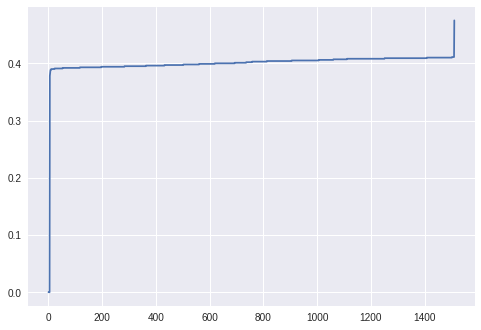

In [177]:
tmpc = dfx_float[names[100]].values
tmpc = np.sort(tmpc)
plt.plot(np.arange(len(tmpc)),tmpc)
plt.show()

In [185]:
fixmin = []
fixmax = []
let3 = []
for n in names:
    fs = set(dfx_float[n])
    fs = np.sort(list(fs))
    if len(fs) <= 3:
        print(n, fs)
        let3.append(n)
    elif len(fs) >3:
        dmin1 = fs[1] - fs[0]
        dmin2 = fs[2] - fs[1]
        if dmin2 == 0 or dmin1/dmin2>7.389:
            print(n, 'too low minimum', dmin1, dmin2)
            fixmin.append(n)
        dmax1 = fs[-1] - fs[-2]
        dmax2 = fs[-2] - fs[-3]
        if dmax2 == 0 or dmax1/dmax2>7.389:
            print(n, 'too high maximum', dmax1, dmax2)
            fixmax.append(n)
print(len(fixmin), len(fixmax), len(let3))

210X1 too low minimum 88.53 0.04
210X2 too low minimum 0.311 0.001
210X4 too low minimum 0.504 0.002
210X4 too high maximum 0.189 0.003
210X5 too low minimum 23.68 0.16
210X10 too low minimum 22.4 0.1
210X12 too low minimum 0.32 0.004
210X13 too low minimum 0.063 0.005
210X14 too low minimum 0.063 0.001
210X14 too high maximum 0.281 0.001
210X15 too low minimum 0.069 0.001
210X16 too low minimum 0.063 0.001
210X18 [ 0.398  0.4  ]
210X20 too low minimum 12.8 0.1
210X23 too low minimum 12.6 0.2
210X24 too low minimum 3906393664.0 6391.0
210X24 too high maximum 2029009.0 2490.0
210X25 too low minimum 0.669 0.001
210X26 too low minimum 0.663 0.001
210X30 [ 0.     0.001]
210X34 too low minimum 0.064 0.001
210X35 too low minimum 0.066 0.001
210X39 too low minimum 37.96 0.13
210X40 too low minimum 0.239 0.003
210X42 too low minimum 0.416 0.001
210X43 too low minimum 0.414 0.001
210X44 too low minimum 0.925 0.001
210X45 too low minimum 0.912 0.001
210X45 too high maximum 0.122 0.004
210X46 too

360X1051 too high maximum 0.9 0.1
360X1135 too low minimum 10.0 0.1
360X1160 [  5.1  19.9  20. ]
360X1276 too low minimum 10.0 0.1
360X1356 too high maximum 38.9 0.3
400X83 too high maximum 765064.0 1532.0
400X84 too high maximum 765178.0 1394.0
400X111 [ 0.          0.05981432  0.1       ]
400X119 [ 5.1  5.1]
400X121 [ 20.3        20.3306366  20.4      ]
400X123 [ 20.2        20.2795756  20.3      ]
400X125 [ 20.4  20.4]
400X145 [ 2.09        2.09681698  2.1       ]
400X146 [ 2.1         2.10442308  2.11      ]
400X147 [ 2.09        2.09373342  2.1       ]
400X148 too low minimum 0.01 0.000152519893856
400X148 too high maximum 0.00984748010614 0.000152519893856
400X150 [-0.1        -0.09980106  0.        ]
400X151 [-0.1        -0.09025199  0.        ]
400X152 [-0.1        -0.09005305  0.        ]
400X153 [-0.2        -0.10046419 -0.1       ]
400X154 [-0.1        -0.09980106  0.        ]
400X156 [-0.1        -0.04834218  0.        ]
400X157 [-0.1        -0.05072944  0.        ]
400X160

750X17 [  9.9  10. ]
750X18 [  9.9  10. ]
750X20 [  9.9  10. ]
750X21 [  9.9  10. ]
750X91 [ 4.   4.9  5. ]
750X94 [ 4.   4.9  5. ]
750X95 [ 4.   4.9  5. ]
750X97 [ 4.   4.9  5. ]
750X98 [ 4.   4.9  5. ]
750X127 too high maximum 0.093 0.002
750X162 too high maximum 0.14 0.00999999999999
750X163 too high maximum 0.14 0.00999999999999
750X173 too high maximum 0.14 0.00999999999999
750X174 too high maximum 0.14 0.00999999999999
750X184 too high maximum 0.14 0.00999999999999
750X208 too high maximum 0.28 0.000999999999999
750X281 too high maximum 0.093 0.006
750X313 too high maximum 0.105 0.012
750X318 too high maximum 0.114 0.004
750X319 too high maximum 0.114 0.004
750X334 too low minimum 0.35 0.01
750X348 too low minimum 0.015 0.002
750X368 too high maximum 0.24 0.02
750X393 too high maximum 0.039 0.002
750X400 too high maximum 0.24 0.02
750X477 too low minimum 0.134 0.013
750X478 too low minimum 0.134 0.013
750X500 too high maximum 0.09 0.001
750X518 too high maximum 1.3 0.1
750X529 to

In [183]:
# for the too low minimum: use fs[1]-fmin2 to replace f[0]
# for the too high maximum: use fs[-2]+fmax2 to replace f[-1]
# for the number of values <=3 : one_hot it